In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

import os
plt.style.use('seaborn-muted')

%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py


range_dict = {
    'a_complete': range(2,8,1),
    'b_complete': range(2,22,2),
    'c_complete': range(2,12,2),
    'd_complete': range(2,22,2),
    'b_reduced': range(2,22,2),
    'c_reduced': range(2,12,2)
}

maes_path = "output_files/maes/baseline/"

Using TensorFlow backend.


In [2]:
## Evaluate baseline results and save to pickle file

path = '../Tax_paper/code/output_files/results/'
# a = os.path.join(path,'suffix_and_remaining_time_helpdesk.csv')
# b = os.path.join(path,'suffix_and_remaining_time_bpi_12_w.csv')
# c = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
# d = os.path.join(path,'suffix_and_remaining_time_env_permit.csv')

b_complete = os.path.join(path,'suffix_and_remaining_time_bpi_12_w.csv')
c_complete = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
b_reduced = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_reduced.csv')
c_reduced = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat_reduced.csv')

b_complete = pd.read_csv(b_complete)
c_complete = pd.read_csv(c_complete)
b_reduced = pd.read_csv(b_reduced)
c_reduced = pd.read_csv(c_reduced)

df_dict = {
    'b_complete': b_complete,
    'c_complete': c_complete,
    'b_reduced': b_reduced,
    'c_reduced': c_reduced
}

for dataset in df_dict.keys():
    tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
    tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
    pickle.dump(list(tmp.values()), open(maes_path + dataset +'.pkl', "wb"))

In [3]:
## Load baseline results
path = 'output_files/maes/baseline/'
baseline_b_reduced  = pickle.load(open(path + 'b_reduced.pkl', 'rb'))
baseline_b_complete = pickle.load(open(path + 'b_complete.pkl', 'rb'))

## Load grid search results single layer
path = 'output_files/maes/single_layer/'
grid_results_b_cen_sl = list(np.squeeze(pickle.load(open(path + 'grid_results_b_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
grid_results_b_obs_sl = list(np.squeeze(pickle.load(open(path + 'grid_results_b_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

path = 'output_files/maes/double_layer/'
grid_results_b_cen_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_b_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
grid_results_b_obs_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_b_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

cases_b = [
    baseline_b_complete,
    baseline_b_reduced,
    grid_results_b_cen_sl,
    grid_results_b_obs_sl,
    grid_results_b_cen_dl,
    grid_results_b_obs_dl]

In [4]:
## Load baseline results
path = 'output_files/maes/baseline/'
baseline_c_reduced  = pickle.load(open(path + 'c_reduced.pkl', 'rb'))
baseline_c_complete = pickle.load(open(path + 'c_complete.pkl', 'rb'))

## Load grid search results double layer

path = 'output_files/maes/single_layer/'
grid_results_c_cen_sl = list(np.squeeze(pickle.load(open(path + 'grid_results_c_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
grid_results_c_obs_sl = list(np.squeeze(pickle.load(open(path + 'grid_results_c_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

path = 'output_files/maes/double_layer/'
grid_results_c_cen_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_c_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
grid_results_c_obs_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_c_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

cases_c = [
    baseline_c_complete,
    baseline_c_reduced,
    grid_results_c_cen_sl,
    grid_results_c_obs_sl,
    grid_results_c_cen_dl,
    grid_results_c_obs_dl]

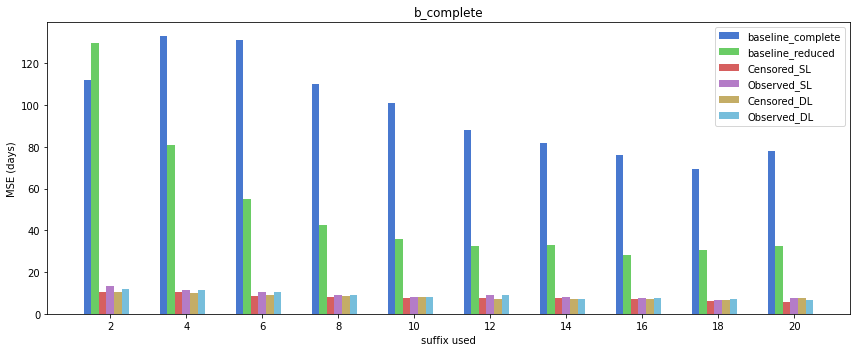

In [5]:
cases = cases_b
labels= ["baseline_complete", "baseline_reduced","Censored_SL", "Observed_SL", "Censored_DL","Observed_DL"]
steps = [-0.6, -0.4,-0.2, 0, 0.2,0.4]


fig, ax = plt.subplots(1, 1, figsize=(12,5))

for i,dataset in enumerate(['b_complete']):

    X = np.array(range_dict[dataset])
    
    for j,case in enumerate(cases):
        plt.bar(x      = X + steps[j], 
                height = case,
                width  = 0.2,
                label = labels[j]);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

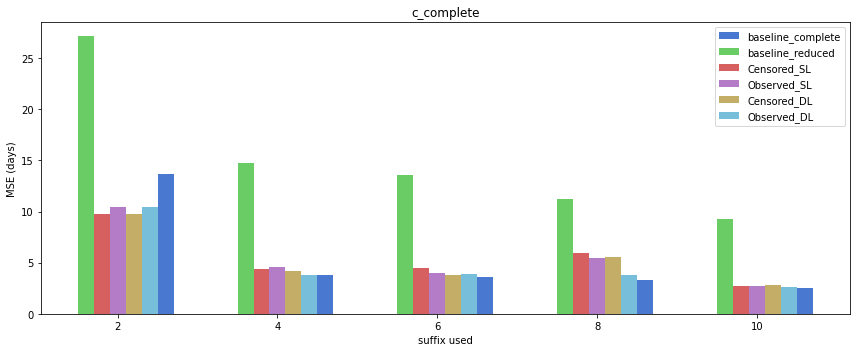

In [6]:
cases = cases_c
labels= ["baseline_complete", "baseline_reduced","Censored_SL", "Observed_SL", "Censored_DL","Observed_DL"]

steps = [0.6,-0.4,-0.2, 0, 0.2,0.4]

fig, ax = plt.subplots(1, 1, figsize=(12,5))

for i,dataset in enumerate(['c_complete']):

    X = np.array(range_dict[dataset])
    
    for j,case in enumerate(cases):
        plt.bar(x      = X + steps[j], 
                height = case,
                width  = 0.2,
                label = labels[j]);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()